# Predikcia 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.pipeline import Pipeline

from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

In [2]:
pd.options.display.width = None
pd.options.display.max_columns = None

In [3]:
from Models import CombineDatasets as d1
from Models import DecodeJSONColumn as d2
from Models import ColumnDropper as d3
from Models import BinaryEncoder as d4
from Models import ClassFixer as d5
from Models import FixDates as d6
from Models import ComputeCurYear as d7
from Models import Replacer as d8
from Models import FillMeasuredColumns as d9
from Models import CountMeasuredHormones as d10
from Models import FillNanNumeric as d11
from Models import PredictNanNumeric as d12
from Models import Classifier as d13
from Models import QuantileReplacer as d14
from Models import Fitter as d15
from Models import ColumnSelector as d16
from Models import Normalizer as d17
from Models import OneHotEncoder as d18

In [4]:
bool_columns = [
    'FTI measured',
    'I131 treatment',
    'T3 measured',
    'goitre',
    'lithium',
    'on thyroxine',
    'pregnant',
    'tumor',
    'query on thyroxine',
    'thyroid surgery',
    'TSH measured',
    'query hyperthyroid',
    'TT4 measured',
    'on antithyroid medication',
    'sick',
    'T4U measured',
    'psych',
    'query hypothyroid'
]

# Zadefinovanie pipelinov pomocou ktorych budeme spracovavat data

In [5]:
from sklearn.pipeline import FeatureUnion

In [6]:
# Transformacna pipelina, ktora robi transformacie nad zadanymi datasetmi
transf_ppl = Pipeline([
    ('combination', d1.CombineDatasets()),
    ('json_decode', d2.DecodeJSONColumn('medical_info')),
    ('drop_columns', d3.ColumnDropper(['hypopituitary', 'TBG measured', 'TBG'])),
    ('binary_fixer', d4.BinaryEncoder(bool_columns)),
    ('class_fix', d5.ClassFixer()),
    ('fix_dates', d6.FixDates()),
    ('compute_cur_year', d7.ComputeCurYear()),
    ('fti_question_mark_to_nan2', d8.Replacer(['FTI'], '?.4', float('nan'), str)),
    ('fti_question_mark_to_nan', d8.Replacer(['FTI'], '?', float('nan'), str)),
    ('fti_question_mark_to_nan1', d8.Replacer(['FTI'], np.nan, float('nan'), str)),
    ('fti_question_mark_to_nan3', d8.Replacer(['FTI'], np.nan, float('nan'), float)),
    ('fill_measured_columns', d9.FillMeasuredColumns()),
    ('count_measured', d10.CountMeasuredHormones('measured_hormones'))
])
    
# Pipelina ktora doplna chybajuce hodnoty
pred_ppl = Pipeline([
    # Fill hormony
    ('fitter', d15.Fitter()),
    ('fill_tt4', d11.FillNanNumeric('mean', 'TT4')),
    ('fill_tsh', d11.FillNanNumeric('median', 'TSH')),
    ('predicted_t3', d12.PredictNanNumeric('T3', ['TT4', 'TSH'])),
    ('predicted_t4u', d12.PredictNanNumeric('T4U', ['TT4', 'TSH'])),
    ('predicted_fti', d12.PredictNanNumeric('FTI', ['TT4', 'TSH', 'T4U'])),
    
    # Fill pregnant
    ('pregnant_predict', d13.Classifier('pregnant', ['T3', 'T4U', 'TT4'])),
    
    # Fill other variables
    ('fill_tumor', d11.FillNanNumeric('median', 'tumor')),
    ('fill_lithium', d11.FillNanNumeric('mean', 'lithium')),
    ('fill_on_thyroxine', d11.FillNanNumeric('mean', 'on thyroxine')),
    ('fill_goitre', d11.FillNanNumeric('most_frequent', 'goitre')),
    ('fill_age', d11.FillNanNumeric('most_frequent', 'age')),
    ('fill_q_on_thyroxine', d11.FillNanNumeric('mean', 'query on thyroxine')),
    
    #Normalize
#     ('normalize_t3', d17.Normalizer('T3', 'log')),
#     ('normalize_t4u', d17.Normalizer('T4U', 'log')),
    ('normalize_tsh', d17.Normalizer('TSH', 'log')),
    ('normalize_tt4', d17.Normalizer('TT4', 'log')),
    ('normalize_fti', d17.Normalizer('FTI', 'log')),

    #Replace outlier
    ('replace_t3', d14.QuantileReplacer('T3')),
    ('replace_age', d14.QuantileReplacer('age')),
    ('replace_t4u', d14.QuantileReplacer('T4U')),
    ('replace_tsh', d14.QuantileReplacer('TSH')),
    ('replace_tt4', d14.QuantileReplacer('TT4')),
    ('replace_fti', d14.QuantileReplacer('FTI')),
    #('column_selector', d16.ColumnSelector(['T3', 'T4U', 'TSH', 'TT4', 'FTI', 'class']))
    ('one_hot_encoder_sex', d18.OneHotEncoder('sex')),
])

## Nacitanie trenovacich dat a ich spracovanie

In [7]:
data_personal_train = pd.read_csv("data/personal_train.csv")
data_other_train = pd.read_csv("data/other_train.csv")

In [8]:
data_train = transf_ppl.fit_transform(data_personal_train, data_other_train)
data_train = pred_ppl.fit_transform(data_train, data_train)

## Nacitanie validacnych dat a ich spracovanie

In [9]:
data_personal_valid = pd.read_csv("data/personal_valid.csv")
data_other_valid = pd.read_csv("data/other_valid.csv")

In [10]:
data_valid = transf_ppl.fit_transform(data_personal_valid, data_other_valid)

In [11]:
mdl_valid = pred_ppl.fit(data_train)
data_valid = mdl_valid.transform(data_valid)

## Nacitanie testovacich dat a ich spracovanie

In [12]:
data_personal_test = pd.read_csv("data/personal_test.csv")
data_other_test = pd.read_csv("data/other_test.csv")

In [13]:
data_test = transf_ppl.fit_transform(data_personal_test, data_other_test)

In [14]:
#mdl = pred_ppl.fit(data_train)
#data_test = mdl.transform(data_test)

----

## Rozhodovacie pravidlá

In [15]:
data_train.groupby('class').count()

,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI measured,I131 treatment,T3,T3 measured,T4U,TSH,TT4,Unnamed: 0_y,capital-gain,capital-loss,education,education-num,fnlwgt,goitre,hours-per-week,lithium,marital-status,native-country,occupation,on thyroxine,pregnant,query on thyroxine,race,referral source,relationship,thyroid surgery,tumor,workclass,TSH measured,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,cur_year,measured_hormones,sex_?,sex_F,sex_M
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
decreased binding protein,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,7,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,6,9,9,9,9,9,9,9,9,9,9,9,9,9,9
increased binding protein,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,91,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97,89,97,97,97,97,97,97,97,97,97,97,97,97,97,97
negative,2131,2131,2131,2131,2131,2130,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,1915,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,1975,2131,2131,2131,2131,2131,2131,2131,2131,2131,2130,2131,2131,2131,2131


In [16]:
#data_train[data_train['class'] == 'increased binding protein']

In [17]:
#sns.pairplot(data_train[data_train['class'] != 'nan'], hue='class', vars=['TT4', 'T4U', 'TSH', 'T3', 'goitre', 'tumor', 'age', 'pregnant'])

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [19]:
def printDistribution(attribute):
    sns.distplot(data_train[data_train['class'] == 'negative'][attribute].dropna())
    sns.distplot(data_train[data_train['class'] == 'increased binding protein'][attribute].dropna())
    sns.distplot(data_train[data_train['class'] == 'decreased binding protein'][attribute].dropna())
    plt.show()    

In [20]:
def test(name, df):
    print(" ********************** Results *************************** ")
    print("Alghoritm used= ")
    print(name)
    print(" ")

    #output = predicted[:, i].reshape(-1, 1)

    print("Accuracy Score= ")
    print(accuracy_score(df['class'], df['class_predicted']))
    print(" ")

    print("Confusion Matrix= ")
    print(confusion_matrix(df['class'], df['class_predicted']))
    print(" ")

    print("Precision/Recall/F1 Score=")
    print(classification_report(df['class'], df['class_predicted']))
    print(" ")

    print("Area Under Curve=")
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(df['class'], df['class_predicted'])
    #roc_auc = auc(false_positive_rate, true_positive_rate)
    #print(roc_auc)

    print(" **********************************************************")

### Pravidlo 1: Ked je T3 vacsi ako 1.5, tak ma increased binding protein

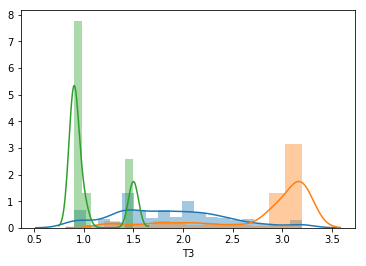

In [21]:
printDistribution('T3')

In [22]:
data_train[data_train['T3'] > 2.].groupby(['class']).count()

,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI measured,I131 treatment,T3,T3 measured,T4U,TSH,TT4,Unnamed: 0_y,capital-gain,capital-loss,education,education-num,fnlwgt,goitre,hours-per-week,lithium,marital-status,native-country,occupation,on thyroxine,pregnant,query on thyroxine,race,referral source,relationship,thyroid surgery,tumor,workclass,TSH measured,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,cur_year,measured_hormones,sex_?,sex_F,sex_M
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
increased binding protein,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,77,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,74,82,82,82,82,82,82,82,82,82,82,82,82,82,82
negative,752,752,752,752,752,752,752,752,752,752,752,752,752,752,752,752,752,675,752,752,752,752,752,752,752,752,752,752,752,752,752,752,752,709,752,752,752,752,752,752,752,752,752,752,752,752,752,752


In [23]:
data_valid['class_predicted'] = data_valid.apply(lambda x: 'increased binding protein' if x['T3'] > 1.4 else 'negative', axis=1)
test('T3', data_valid)

 ********************** Results *************************** 
Alghoritm used= 
T3
 
Accuracy Score= 
0.3168724279835391
 
Confusion Matrix= 
[[  0   0   5]
 [  0  23   2]
 [  0 657 285]]
 
Precision/Recall/F1 Score=
                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         5
increased binding protein       0.03      0.92      0.07        25
                 negative       0.98      0.30      0.46       942

                micro avg       0.32      0.32      0.32       972
                macro avg       0.34      0.41      0.18       972
             weighted avg       0.95      0.32      0.45       972

 
Area Under Curve=
 **********************************************************


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
data_valid[data_valid['class_predicted'] != 'negative']

,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI measured,I131 treatment,T3,T3 measured,T4U,TSH,TT4,Unnamed: 0_y,capital-gain,capital-loss,class,education,education-num,fnlwgt,goitre,hours-per-week,lithium,marital-status,native-country,occupation,on thyroxine,pregnant,query on thyroxine,race,referral source,relationship,thyroid surgery,tumor,workclass,TSH measured,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,cur_year,measured_hormones,sex_?,sex_F,sex_M,class_predicted
0,0,Walter Acosta,"55866 Nicholson View\nTraviston, LA 41078",55.0,M,2063-07-13,1,0.0,1.6,1,0.93,1.60,114.0,514.000000,0.0,0.0,negative,Bachelors,13.0,234690.0,0,40.0,0.0,Married-civ-spouse,Cuba,Adm-clerical,0.0,0,0.0,White,other,Husband,0,0.0,Private,1,0.0,1,0.0,123.000000,0.0,1,0.0,0.0,2118,5,0,0,1,increased binding protein
1,1,Frances Pryor,"68243 Nathan Pines Suite 570\nChristinaberg, S...",26.0,F,1992-04-06,1,0.0,3.2,1,1.28,0.20,122.0,842.000000,0.0,0.0,increased binding protein,Some-college,10.0,155977.0,0,54.0,0.0,Widowed,United-States,?,1.0,1,0.0,Black,other,Unmarried,0,0.0,?,1,0.0,1,0.0,96.000000,0.0,1,0.0,0.0,2018,5,0,1,0,increased binding protein
3,3,Gloria Lepley,"36893 Garcia Walk Apt. 689\nBelindastad, AR 60040",64.0,F,1953-12-20,1,0.0,1.5,1,0.95,3.30,102.0,726.000000,0.0,0.0,negative,HS-grad,9.0,225135.0,0,40.0,0.0,Never-married,United-States,Machine-op-inspct,0.0,0,0.0,White,SVHC,Unmarried,0,0.0,Private,1,0.0,1,0.0,108.000000,0.0,1,0.0,0.0,2017,5,0,1,0,increased binding protein
6,6,Jesus Reichel,"9077 Mendez View\nStokesborough, VA 21063",59.0,?,1959-09-03,1,1.0,2.4,1,0.97,0.25,109.0,626.000000,0.0,0.0,negative,Some-college,10.0,538243.0,0,40.0,0.0,Separated,United-States,Tech-support,0.0,0,0.0,Black,other,Unmarried,0,0.0,Private,1,0.0,1,0.0,113.000000,0.0,1,0.0,0.0,2018,5,1,0,0,increased binding protein
7,7,John Nichols,"484 Jeremy Dale Apt. 588\nDelgadoport, KS 97822",47.0,?,1971-06-06,1,0.0,1.9,1,0.93,0.03,111.0,291.000000,0.0,0.0,negative,Some-college,10.0,433624.0,0,40.0,0.0,Never-married,United-States,Adm-clerical,0.0,0,0.0,White,other,Not-in-family,0,0.0,Private,1,0.0,1,0.0,119.000000,1.0,1,0.0,0.0,2018,5,1,0,0,increased binding protein
8,8,Everett Guarino,"444 David Brook\nNew Jennatown, MS 14540",53.0,M,1965-08-14,1,0.0,2.2,1,0.83,0.05,89.0,134.000000,7298.0,0.0,negative,Doctorate,16.0,230329.0,0,40.0,0.0,Married-civ-spouse,United-States,Prof-specialty,0.0,0,0.0,White,other,Husband,0,0.0,State-gov,1,0.0,1,1.0,107.000000,0.0,1,0.0,0.0,2018,5,0,0,1,increased binding protein
10,10,Henry Alexander,Unit 9057 Box 3877\nDPO AA 29489,55.0,?,1963-05-23,1,0.0,1.6,0,1.03,0.59,118.0,136.000000,0.0,0.0,negative,Some-college,10.0,243660.0,0,45.0,0.0,Never-married,United-States,Other-service,0.0,0,0.0,White,SVHC,Not-in-family,0,0.0,Private,1,0.0,1,0.0,114.000000,0.0,1,1.0,1.0,2018,4,1,0,0,increased binding protein
12,12,Lyndia Yoshino,"658 Benitez Skyway Apt. 208\nWest Wendyside, I...",58.0,F,1960-06-09,1,0.0,2.6,0,0.90,0.20,169.0,463.000000,15024.0,0.0,negative,Prof-school,15.0,161309.0,0,50.0,0.0,Married-civ-spouse,United-States,?,0.0,0,0.0,White,Other,Wife,0,0.0,NaN,1,1.0,1,0.0,173.352880,0.0,1,0.0,1.0,2018,4,0,1,0,increased binding protein
13,13,Flora Mcgee,24886 Michael Mountains Suite 468\nEast Rachel...,42.0,F,1976-04-18,1,0.0,2.6,1,1.01,0.03,169.0,829.000000,0.0,0.0,negative,Some-college,10.0,151588.0,0,40.0,0.0,Married-spouse-absent,United-States,Sales,1.0,0,0.0,White,other,Not-in-family,0,0.0,Private,1,0.0,1,0.0,173.352880,0.0,1,0.0,0.0,2018,5,0,1,0,increased binding protein
16,16,Lillian Batchelor,USCGC Brown\nFPO AP 70766,35.0,F,1983-06-30,1,0.0,2.3,1,1.19,2.30,83.0,974.000000,4101.0,0.0,negative,Some-college,10.0,104413.0,0,40.0,0.0,Separated,United-States,Tech-support,0.0,0,0.0,Black,SVHC,Other-relative,0,0.0,Private,1,0.0,1,0.0,71.000000,0.0,1,0.0,0.0,2018,5,0,1,0,increased binding protein


### Pravidlo 2: Ked je T4U vacsi ako 0.25, tak ma increased binding protein

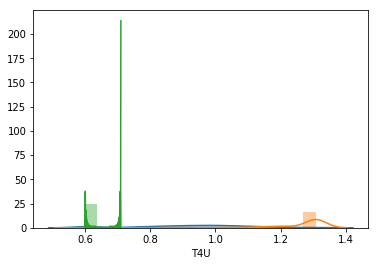

In [25]:
printDistribution('T4U')

In [26]:
data_train[data_train['T4U'] > 1.1].groupby(['class']).count()

,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI measured,I131 treatment,T3,T3 measured,T4U,TSH,TT4,Unnamed: 0_y,capital-gain,capital-loss,education,education-num,fnlwgt,goitre,hours-per-week,lithium,marital-status,native-country,occupation,on thyroxine,pregnant,query on thyroxine,race,referral source,relationship,thyroid surgery,tumor,workclass,TSH measured,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,cur_year,measured_hormones,sex_?,sex_F,sex_M
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
increased binding protein,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,80,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,78,86,86,86,86,86,86,86,86,86,86,86,86,86,86
negative,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330,299,330,330,330,330,330,330,330,330,330,330,330,330,330,330,330,309,330,330,330,330,330,330,330,330,330,330,330,330,330,330


In [27]:
data_valid['class_predicted'] = data_valid['T4U'].apply(lambda x: 'increased binding protein' if x > 1.1 else 'negative')
test('T4U', data_valid)

 ********************** Results *************************** 
Alghoritm used= 
T4U
 
Accuracy Score= 
0.8281893004115226
 
Confusion Matrix= 
[[  0   0   5]
 [  0  23   2]
 [  0 160 782]]
 
Precision/Recall/F1 Score=
                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         5
increased binding protein       0.13      0.92      0.22        25
                 negative       0.99      0.83      0.90       942

                micro avg       0.83      0.83      0.83       972
                macro avg       0.37      0.58      0.37       972
             weighted avg       0.96      0.83      0.88       972

 
Area Under Curve=
 **********************************************************


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Pravidlo 3: Ked je zena po 25 tehotna, tak ma increased binding protein

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


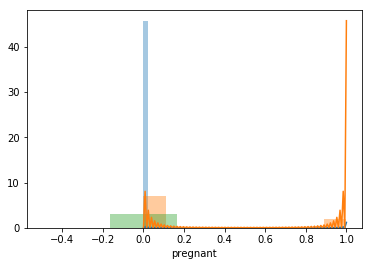

In [28]:
printDistribution('pregnant')

In [29]:
data_train[(data_train['pregnant'] > 0.85) & (data_train['age'] > 25)].groupby(['class']).count()

,Unnamed: 0_x,name,address,age,sex,date_of_birth,FTI measured,I131 treatment,T3,T3 measured,T4U,TSH,TT4,Unnamed: 0_y,capital-gain,capital-loss,education,education-num,fnlwgt,goitre,hours-per-week,lithium,marital-status,native-country,occupation,on thyroxine,pregnant,query on thyroxine,race,referral source,relationship,thyroid surgery,tumor,workclass,TSH measured,query hyperthyroid,TT4 measured,on antithyroid medication,FTI,sick,T4U measured,psych,query hypothyroid,cur_year,measured_hormones,sex_?,sex_F,sex_M
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
increased binding protein,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,20,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,18,21,21,21,21,21,21,21,21,21,21,21,21,21,21
negative,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [30]:
def ruleAgePregnant(row):
    if row['pregnant'] > 0.85 and row['age'] > 25:
        return 'increased binding protein'
    return 'negative'
data_valid['class_predicted'] = data_valid.apply(lambda x: ruleAgePregnant(x), axis=1)
test('pregnant', data_valid)

 ********************** Results *************************** 
Alghoritm used= 
pregnant
 
Accuracy Score= 
0.9691358024691358
 
Confusion Matrix= 
[[  0   0   5]
 [  0   5  20]
 [  0   5 937]]
 
Precision/Recall/F1 Score=
                           precision    recall  f1-score   support

decreased binding protein       0.00      0.00      0.00         5
increased binding protein       0.50      0.20      0.29        25
                 negative       0.97      0.99      0.98       942

                micro avg       0.97      0.97      0.97       972
                macro avg       0.49      0.40      0.42       972
             weighted avg       0.96      0.97      0.96       972

 
Area Under Curve=
 **********************************************************


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


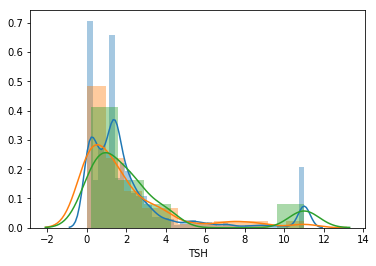

In [31]:
printDistribution('TSH')

In [32]:
#data_train[(data_train['TSH'] < 0) & (data_train['age'] < 40)].groupby(['class']).count()

----

# Rozhodovaci strom

In [33]:
def score(name, predicted, valid):
    print(" ********************** Results *************************** ")
    print("Alghoritm used= ")
    print(name)
    print(" ")

    #output = predicted[:, i].reshape(-1, 1)

    print("Accuracy Score= ")
    print(accuracy_score(valid, predicted))
    print(" ")

    print("Confusion Matrix= ")
    print(confusion_matrix(valid, predicted))
    print(" ")

    print("Precision/Recall/F1 Score=")
    print(classification_report(valid, predicted))
    print(" ")

    print(" **********************************************************")

In [135]:
reduce_ppl = Pipeline([
    ('column_selector', d16.ColumnSelector(['T3', 'T4U', 'TSH', 'TT4', 'FTI', 'class', 'sex_F', 'sex_M', 'pregnant'])),
])

In [136]:
data_train_selected = reduce_ppl.transform(data_train)
data_valid_selected = reduce_ppl.transform(data_valid)

In [137]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [138]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

In [139]:
# Rozdelenie trenovacich dat pre natrenovanie klasifikatoru
X_train = data_train_selected.drop(['class'], axis=1)
Y_train = le.fit_transform(data_train_selected[['class']])
#Y_train = data_train[['class']]

# Rozdelenie validacnych dat
X_valid = data_valid_selected.drop(['class'], axis=1)
Y_valid = le.fit_transform(data_valid_selected[['class']])
#Y_valid = data_valid[['class']]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [140]:
ss = pd.DataFrame(Y_valid)
ss[0].value_counts()

2    942
1     25
0      5
Name: 0, dtype: int64

In [141]:
data_valid['class'].value_counts()

negative                     942
increased binding protein     25
decreased binding protein      5
Name: class, dtype: int64

In [142]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
class_weights

array([82.85185185,  7.68728522,  0.34991397])

In [143]:
clf = RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200) #{2:0.35, 1:7.68, 0:82.51}'balanced'

clf.fit(X_train, Y_train)
predictions = clf.predict(X_valid)

In [144]:
score("CART", Y_valid, predictions)

 ********************** Results *************************** 
Alghoritm used= 
CART
 
Accuracy Score= 
0.9732510288065843
 
Confusion Matrix= 
[[  1   0   0]
 [  0  14  11]
 [  4  11 931]]
 
Precision/Recall/F1 Score=
              precision    recall  f1-score   support

           0       0.20      1.00      0.33         1
           1       0.56      0.56      0.56        25
           2       0.99      0.98      0.99       946

   micro avg       0.97      0.97      0.97       972
   macro avg       0.58      0.85      0.63       972
weighted avg       0.98      0.97      0.97       972

 
 **********************************************************


In [145]:
X_valid.head()

,T3,T4U,TSH,TT4,FTI,sex_F,sex_M,pregnant
0,1.6,0.93,1.6,114.0,123.0,0,1,0
1,3.2,1.28,0.2,122.0,96.0,1,0,1
2,1.4,1.08,1.3,131.0,121.0,1,0,0
3,1.5,0.95,3.3,102.0,108.0,1,0,0
4,0.9,0.97,3.5,68.0,71.0,1,0,0


In [146]:
clf = DecisionTreeClassifier(class_weight='balanced', max_depth=10) #{2:0.35, 1:7.68, 0:82.51}'balanced'
clf.fit(X_train, Y_train)
predictions = clf.predict(X_valid)

In [147]:
score("CART", Y_valid, predictions)

 ********************** Results *************************** 
Alghoritm used= 
CART
 
Accuracy Score= 
0.9598765432098766
 
Confusion Matrix= 
[[  3   0   3]
 [  0  19  28]
 [  2   6 911]]
 
Precision/Recall/F1 Score=
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.76      0.40      0.53        47
           2       0.97      0.99      0.98       919

   micro avg       0.96      0.96      0.96       972
   macro avg       0.78      0.63      0.68       972
weighted avg       0.95      0.96      0.95       972

 
 **********************************************************


In [148]:
from sklearn.linear_model import LogisticRegression

In [149]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, Y_train)

predictions = lr.predict(X_valid)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [119]:
score("Logistic Regression", Y_valid, predictions)

 ********************** Results *************************** 
Alghoritm used= 
Logistic Regression
 
Accuracy Score= 
0.9732510288065843
 
Confusion Matrix= 
[[  0   0   0]
 [  0  12   8]
 [  5  13 934]]
 
Precision/Recall/F1 Score=
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.48      0.60      0.53        20
           2       0.99      0.98      0.99       952

   micro avg       0.97      0.97      0.97       972
   macro avg       0.49      0.53      0.51       972
weighted avg       0.98      0.97      0.98       972

 
 **********************************************************


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


- Age
- One hot encoding